In [160]:
import pandas as pd
import csv
import requests
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


Capture dataset

In [161]:
# Source: (#https://drive.google.com/drive/folders/1r095ofG8YvNj_dMWEq4XKkfhDaF8-I0n?usp=drive_link)
csv_path= "covid19_vaccine_2023-05-09.csv"
vaxmfc_df = pd.read_csv(csv_path)

vaxmfc_df


,section,category,metric,type,date,value,publish_date
0,State Data,Cumulative counts to date,Total Vaccine Providers,All COVID Vaccines,NaN,2154.000,2023-05-09
1,State Data,Cumulative counts to date,People Immunized With One Dose,All COVID Vaccines,NaN,4527145.000,2023-05-09
2,State Data,Cumulative counts to date,Eligible People Immunized With One Dose,All COVID Vaccines,NaN,0.787,2023-05-09
3,State Data,Cumulative counts to date,People Fully Immunized,All COVID Vaccines,NaN,4114705.000,2023-05-09
4,State Data,Cumulative counts to date,Eligible People Fully Immunized,All COVID Vaccines,NaN,0.715,2023-05-09
...,...,...,...,...,...,...,...
30369,County-level Data,NaN,Chaffee,All Ages,NaN,0.269,2023-05-09
30370,County-level Data,NaN,Mineral,All Ages,NaN,0.278,2023-05-09
30371,County-level Data,NaN,Broomfield,All Ages,NaN,0.280,2023-05-09
30372,County-level Data,NaN,Boulder,All Ages,NaN,0.309,2023-05-09


Begin data cleanup, removing unnecessary rows by keeping only the Vax Admin and Daily Count rows, while dropping the pub date column

In [162]:
#clean data and return only Vaccine Administration and Weekly Counts rows
vaxmfc_df = vaxmfc_df[vaxmfc_df['section'] == "Vaccine Administration"]
vaxmfc_df = vaxmfc_df[vaxmfc_df['metric'] == "Daily Counts"]
vaxmfc_df = vaxmfc_df.drop(columns=["publish_date"])
vaxmfc_df.head()


,section,category,metric,type,date,value
32,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-12T00:00:00Z,0.0
33,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-13T00:00:00Z,0.0
34,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-14T00:00:00Z,0.0
35,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-15T00:00:00Z,0.0
36,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-16T00:00:00Z,0.0


Need unique type IDs

In [163]:
#Obtain unique values in types
unique_types = vaxmfc_df['type'].unique()
print(unique_types)

['Additional & Booster Doses, Janssen'
 'Additional & Booster Doses, Moderna'
 'Additional & Booster Doses, Novavax' 'Additional & Booster Doses, Other'
 'Additional & Booster Doses, Pfizer' 'Omicron Doses, Moderna'
 'Omicron Doses, Other' 'Omicron Doses, Pfizer' 'NA, Pfizer'
 'Primary Series Doses, Janssen' 'Primary Series Doses, Moderna'
 'Primary Series Doses, Novavax' 'Primary Series Doses, Other'
 'Primary Series Doses, Pfizer']


Removing specific rows with values within "types" identified by the .unique

In [164]:
#Set types to be removed in this analyisis that are manufactureres listed as "Other"
remove_types = ['Additional & Booster Doses, Other', 'Omicron Doses, Other', 'Primary Series Doses, Other']

#Delete rows specified by remove_type
vaxmfc_df = vaxmfc_df[vaxmfc_df['type'].isin(remove_types)== False]

print(vaxmfc_df)

                      section        category        metric  \
32     Vaccine Administration  Administration  Daily Counts   
33     Vaccine Administration  Administration  Daily Counts   
34     Vaccine Administration  Administration  Daily Counts   
35     Vaccine Administration  Administration  Daily Counts   
36     Vaccine Administration  Administration  Daily Counts   
...                       ...             ...           ...   
12319  Vaccine Administration  Administration  Daily Counts   
12320  Vaccine Administration  Administration  Daily Counts   
12321  Vaccine Administration  Administration  Daily Counts   
12322  Vaccine Administration  Administration  Daily Counts   
12323  Vaccine Administration  Administration  Daily Counts   

                                      type                  date  value  
32     Additional & Booster Doses, Janssen  2020-12-12T00:00:00Z    0.0  
33     Additional & Booster Doses, Janssen  2020-12-13T00:00:00Z    0.0  
34     Additional & B

Handling data discrepancy - a type of Pfizer vax administration is counted separate from primay or additional/booster, count of vaccines involved is small (7000 vs the several millions). I'll aggregate those vax count 'values' into Additional and Booster, Pfizer rows.

In [165]:
# Combine 'NA, Pfizer' values into 'Additional & Booster Doses, Pfizer'
na_pfizer_sum = vaxmfc_df.loc[vaxmfc_df['type'] == 'NA, Pfizer', 'value'].sum()
vaxmfc_df.loc[vaxmfc_df['type'] == 'Additional & Booster Doses, Pfizer', 'value'] += na_pfizer_sum

# Remove 'NA, Pfizer' from the DataFrame
vaxmfc_df = vaxmfc_df[vaxmfc_df['type'] != 'NA, Pfizer']

unique_types = vaxmfc_df['type'].unique()
print(unique_types)

['Additional & Booster Doses, Janssen'
 'Additional & Booster Doses, Moderna'
 'Additional & Booster Doses, Novavax'
 'Additional & Booster Doses, Pfizer' 'Omicron Doses, Moderna'
 'Omicron Doses, Pfizer' 'Primary Series Doses, Janssen'
 'Primary Series Doses, Moderna' 'Primary Series Doses, Novavax'
 'Primary Series Doses, Pfizer']


In [166]:
vaxmfc_df

,section,category,metric,type,date,value
32,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-12T00:00:00Z,0.0
33,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-13T00:00:00Z,0.0
34,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-14T00:00:00Z,0.0
35,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-15T00:00:00Z,0.0
36,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-16T00:00:00Z,0.0
...,...,...,...,...,...,...
12319,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-04T00:00:00Z,203.0
12320,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-05T00:00:00Z,186.0
12321,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-06T00:00:00Z,54.0
12322,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-07T00:00:00Z,28.0


Ensure value column for the remaining data is in int format. ensure date is a date format/dropping time zone to bypass a later error while our time zone is not relevant to our analysis. Also, dropping the day of the month to report only based on monthly vax admins.

In [167]:
#convert value to int and make dates dates
vaxmfc_df['value'] = vaxmfc_df['value'].astype(int)
vaxmfc_df['date'] = pd.to_datetime(vaxmfc_df['date'])
vaxmfc_df['date'] = vaxmfc_df['date'].dt.tz_localize(None)

#create year-month column
vaxmfc_df['year-month'] = vaxmfc_df['date'].dt.to_period('M')
vaxmfc_df

,section,category,metric,type,date,value,year-month
32,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-12,0,2020-12
33,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-13,0,2020-12
34,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-14,0,2020-12
35,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-15,0,2020-12
36,Vaccine Administration,Administration,Daily Counts,"Additional & Booster Doses, Janssen",2020-12-16,0,2020-12
...,...,...,...,...,...,...,...
12319,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-04,203,2023-05
12320,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-05,186,2023-05
12321,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-06,54,2023-05
12322,Vaccine Administration,Administration,Daily Counts,"Primary Series Doses, Pfizer",2023-05-07,28,2023-05


create new data frame with needed columns, specified range of months, and values of vaxes summed by month/type. Future deprecation warning was present, but I was unable to address this at this time.

In [168]:
date_ranges = {
    2020: ('2020-03-01', '2020-12-31'),
    2021: ('2021-01-01', '2021-12-31'),
    2022: ('2022-01-01', '2022-12-31'),
    2023: ('2023-01-01', '2023-05-09')
}

# Initialize the final DataFrame
mfc_month_df = pd.DataFrame(columns=['type', 'year-month', 'value'])

for year, (start_date, end_date) in date_ranges.items():
    # Filter data based on the date range
    filtering_df = vaxmfc_df[(vaxmfc_df['year-month'] >= start_date) & (vaxmfc_df['year-month'] <= end_date)]

    # Group by type and year-month, summing the values
    sum_values_by_type_month = filtering_df.groupby(['type', 'year-month'])['value'].sum().reset_index()

    mfc_month_df = pd.concat([mfc_month_df, sum_values_by_type_month], ignore_index=True)

# Infer types
mfc_month_df = mfc_month_df.infer_objects(copy=False)

# Display the final DataFrame
mfc_month_df

C:\Users\snark\AppData\Local\Temp\ipykernel_36508\1874071273.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mfc_month_df = pd.concat([mfc_month_df, sum_values_by_type_month], ignore_index=True)


,type,year-month,value
0,"Additional & Booster Doses, Janssen",2020-12,0
1,"Additional & Booster Doses, Moderna",2020-12,0
2,"Additional & Booster Doses, Novavax",2020-12,0
3,"Additional & Booster Doses, Pfizer",2020-12,137980
4,"Omicron Doses, Moderna",2020-12,0
...,...,...,...
295,"Primary Series Doses, Pfizer",2023-01,11336
296,"Primary Series Doses, Pfizer",2023-02,6885
297,"Primary Series Doses, Pfizer",2023-03,6495
298,"Primary Series Doses, Pfizer",2023-04,5019


changing column order

In [169]:
mfc_month_df = mfc_month_df[['year-month', 'type', 'value']]
mfc_month_df.reset_index(drop=True, inplace=True)
mfc_month_df

,year-month,type,value
0,2020-12,"Additional & Booster Doses, Janssen",0
1,2020-12,"Additional & Booster Doses, Moderna",0
2,2020-12,"Additional & Booster Doses, Novavax",0
3,2020-12,"Additional & Booster Doses, Pfizer",137980
4,2020-12,"Omicron Doses, Moderna",0
...,...,...,...
295,2023-01,"Primary Series Doses, Pfizer",11336
296,2023-02,"Primary Series Doses, Pfizer",6885
297,2023-03,"Primary Series Doses, Pfizer",6495
298,2023-04,"Primary Series Doses, Pfizer",5019


(Re-?) converting year/month to a timestamp

In [170]:
mfc_month_df['year-month'] = mfc_month_df['year-month'].dt.to_timestamp()
mfc_month_df

,year-month,type,value
0,2020-12-01,"Additional & Booster Doses, Janssen",0
1,2020-12-01,"Additional & Booster Doses, Moderna",0
2,2020-12-01,"Additional & Booster Doses, Novavax",0
3,2020-12-01,"Additional & Booster Doses, Pfizer",137980
4,2020-12-01,"Omicron Doses, Moderna",0
...,...,...,...
295,2023-01-01,"Primary Series Doses, Pfizer",11336
296,2023-02-01,"Primary Series Doses, Pfizer",6885
297,2023-03-01,"Primary Series Doses, Pfizer",6495
298,2023-04-01,"Primary Series Doses, Pfizer",5019


Create vax series by manufacturer over months line plot, for loop to cycle through all yearmonth/type combinations using the summed monthly values.
found plt.ticklabel_format(style='plain', axis='y') able to prevent y values from converting to scientific notation. bbox_tight to try to help when exporting to jpeg and copying incorrectly into a PPT.

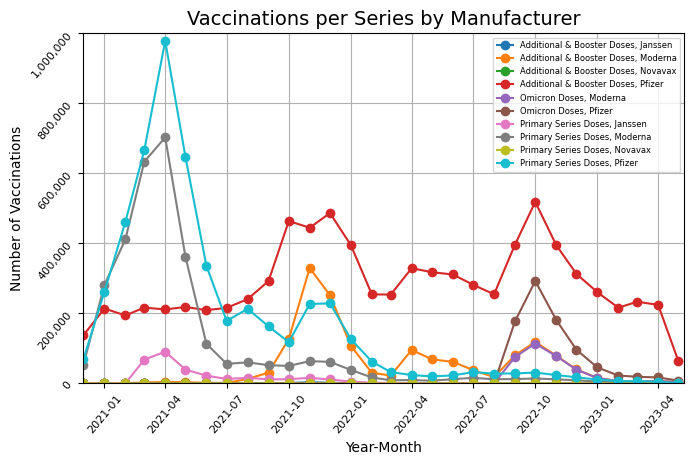

In [171]:
unique_vax_types = mfc_month_df["type"].unique()

plt.figure(figsize=(7, 4.75))

for vax_type in unique_vax_types:
    vax_type_data = mfc_month_df[mfc_month_df["type"] == vax_type]
    plt.plot(vax_type_data["year-month"], vax_type_data["value"], marker='o', label=vax_type)

plt.xlabel('Year-Month', fontsize='10')
plt.ylabel('Number of Vaccinations', fontsize='10')

plt.xlim(pd.Timestamp('2020-12-01'), pd.Timestamp('2023-05-10'))
plt.xticks(rotation=50, fontsize='8')

plt.ylim([0,1000000])
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(rotation=50, fontsize ='8')

plt.title(f'Vaccinations per Series by Manufacturer', fontsize='14')
plt.legend(loc='upper right', fontsize='6')
plt.grid(True)

plt.tight_layout()

formatter = mtick.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.savefig("Timeline_Vax_Series_Mfc.jpeg", bbox_inches="tight")

plt.show()

In [172]:
mfc_month_df

,year-month,type,value
0,2020-12-01,"Additional & Booster Doses, Janssen",0
1,2020-12-01,"Additional & Booster Doses, Moderna",0
2,2020-12-01,"Additional & Booster Doses, Novavax",0
3,2020-12-01,"Additional & Booster Doses, Pfizer",137980
4,2020-12-01,"Omicron Doses, Moderna",0
...,...,...,...
295,2023-01-01,"Primary Series Doses, Pfizer",11336
296,2023-02-01,"Primary Series Doses, Pfizer",6885
297,2023-03-01,"Primary Series Doses, Pfizer",6495
298,2023-04-01,"Primary Series Doses, Pfizer",5019


Next plot is manufacturer agnostic. Dropped manufacturer names, aggregated monthly totals by mfc to quarterly totals for each series.

In [173]:
#create series without mfc.
mfc_month_df['series_types'] = mfc_month_df['type'].str.replace(r',.*', '', regex=True)
types_to_keep = ["Additional & Booster Doses", "Omicron Doses", "Primary Series Doses"]
filtered_df = mfc_month_df[mfc_month_df['series_types'].isin(types_to_keep)]

#Convert 'year-month' to quarters
filtered_df['quarter'] = pd.to_datetime(filtered_df['year-month']).dt.to_period('Q')

#generate values from groupby with quarter/series combinations
series_df = filtered_df.groupby(['quarter', 'series_types'])['value'].sum().reset_index()

#swap columns and rows
pivot_df = series_df.pivot(index='quarter', columns='series_types', values='value').fillna(0)

pivot_df

series_types,Additional & Booster Doses,Omicron Doses,Primary Series Doses
quarter,,,
2020Q4,137980,0,124425
2021Q1,629067,5,2783774
2021Q2,649519,16,3292275
2021Q3,795107,52,765164
2021Q4,2111361,378,789343
2022Q1,1064658,213,295676
2022Q2,1185042,291,99218
2022Q3,1070411,253275,131578
2022Q4,1465458,802078,108912


Swapped order of columns to ensure plot orders bar chart correctly.

In [174]:
# Ensure 'Primary Series Doses' is at the bottom, 'Additional & Booster Doses' in the middle, and 'Omicron Doses' at the top
ordered_columns = ['Primary Series Doses', 'Additional & Booster Doses', 'Omicron Doses']
pivot_df = pivot_df[ordered_columns]
pivot_df

series_types,Primary Series Doses,Additional & Booster Doses,Omicron Doses
quarter,,,
2020Q4,124425,137980,0
2021Q1,2783774,629067,5
2021Q2,3292275,649519,16
2021Q3,765164,795107,52
2021Q4,789343,2111361,378
2022Q1,295676,1064658,213
2022Q2,99218,1185042,291
2022Q3,131578,1070411,253275
2022Q4,108912,1465458,802078


Creating bar plot for mfc agnostic series values

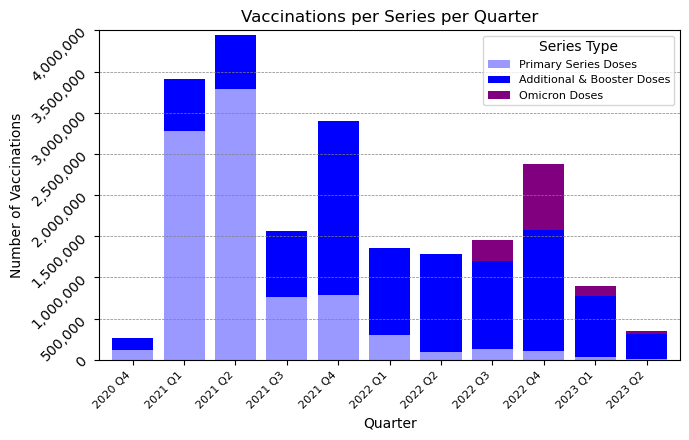

In [175]:
#set colors to use for series
colors = ['#9999FF', '#0000FF', '#800080']

# Create the stacked bar plot
pivot_df.plot(kind='bar', stacked=True, figsize=(7, 4.5), width=0.8, color=colors)

# Modify plot presentation
plt.xlabel('Quarter', fontsize='10')
plt.ylabel('Number of Vaccinations', fontsize='10')
plt.title('Vaccinations per Series per Quarter', fontsize='12')
plt.legend(title='Series Type', loc='upper right', fontsize='8')
#plt.xticks(rotation=45, fontsize='8')

#add a space between the year and the quarter
new_labels = [f"{str(quarter)[:4]} {str(quarter)[4:]}" for quarter in pivot_df.index]
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right', fontsize='8')

plt.ylim([0, 4000000])
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(rotation=45, fontsize='10')

# Add only horizontal grid lines and make them lighter
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')

# Comma-delimited numbers for y-ticks
formatter = mtick.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()

# Save the plot
plt.savefig("Vax_Series_Quarterly.jpeg", bbox_inches="tight")

# Show the plot
plt.show()